<h1>DEEP-EMOTIVE</h1>
<h2>Trabalho de conclusão de curso - Ciência da Computação  - FURB - 2017</h2>
<h3>Autor: Diogenes Ademir Domingos<br>
 Modulo de transferência de aprendizado<br>
 Base de dados Facial Expression Recognition 2013 (FER-2013)</h3>

<p>Deep-Emotive é um protótipo para reconhecer e classificar as expressões faciais das emoções, alegria, desgosto, medo, raiva, surpresa, tristeza, consideradas por Ekman et al. (1987), como básicas e universais, utilizando técnicas já consolidadas das áreas de Processamento Digital de Imagem e Visão Computacional. Estas técnicas são combinadas com uma nova abordagem, considerada a mais avançada no reconhecimento visual de objetos através do aprendizado de máquina, o Aprendizado Profundo ou Deep Learning.</p>

<p>A transferência de aprendizado consiste em utilizar um conhecimento adquirido na resolução de um problema e aplicá-lo a um novo problema relacionado a este. As amostras desta base de dados estão distribuídas em:  7215 imagens de alegria; 436 de desgosto; 4097 de medo; 4965 de neutra; 3995 de raiva; 3171 de surpresa; e 4830 de tristeza. Esta base de dados se enquadra na quarta categoria de transferência de aprendizado, pois ela possui 28709 imagens, porém é dissimilar para com a base de dados utilizada para o treinamento da rede DeepEmotive.</p>

<p>O resultado desempenhado pela rede DeepEmotive nesta base de dados foi razoável. A rede alcançou a precisão de 60,62%. Porém, a rede DeepEmotive provou possuir um algoritmo robusto, tendo em vista que a precisão de classificação é superior à taxa de escolha randômica de 50% (KEARNS; VALIANT, 1994).</p>

In [1]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import pandas as pd
import itertools
import csv

# Modulo para trabalhar com de coleções em forma de dicionarios
from collections import OrderedDict

# Referência: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
from mpl_toolkits.axes_grid1 import make_axes_locatable

# biblioteca para trabalhar com imagens
from PIL import Image, ImageEnhance

# Scikitlearn
from sklearn.utils import shuffle
#from sklearn.cross_validation import train_test_split #cross_validation is deprecated

# Configunrando o framework Keras.

# Importando o modelo do Keras (https://keras.io/getting-started/sequential-model-guide/)
from keras.models import Sequential

# Importando modelo para salvar e importar a DNN
from keras.models import model_from_json, load_model

# Importando o tipo de camada
from keras.layers import Input,Dense

from keras.layers import merge

# Importando modulo de Dropout da rede, para aplicar mutações.
from keras.layers import Dropout

from keras.layers import Activation

# Importando modulo de achatamento dos vetores.
# Aprimora a entrada. Não afeta o tamanho do lote.
# (https://keras.io/layers/core/#flatten)
from keras.layers import Flatten

# Importando modulo para explrar as camadas do modelo
from keras.models import Model

# Importanto modulo de convolução (https://keras.io/layers/convolutional/)
from keras.layers.convolutional import Conv2D

# Importando modulo para trabalhar com as bordas da imagem (https://keras.io/layers/convolutional/#zeropadding2d)
from keras.layers.convolutional import ZeroPadding2D

# Importando modulo para normalizar a imagem (https://keras.io/layers/convolutional/#zeropadding2d)
from keras.layers.normalization import BatchNormalization

# Importando modulo de subamostragem (https://keras.io/layers/pooling/)
from keras.layers.convolutional import MaxPooling2D

from keras.layers.pooling import AveragePooling2D

# Importando Lib de utilidades (https://keras.io/utils/)
from keras.utils import np_utils

# Importante modulo de trabalho em backend (Th ou Tf) (https://keras.io/backend/)
from keras import backend as K

# modulo para trabalhar reprocessar as imagens
from keras.preprocessing import image

# modulo de utilizades para trabalhar reprocessar as imagens
from keras.utils.data_utils import get_file

# modulo de callback para parar o treinamento na melhor opção
from keras.callbacks import EarlyStopping, ModelCheckpoint

# fine tunnig
from keras import optimizers

# ativadores avançados
from keras.layers.advanced_activations import LeakyReLU, PReLU

# Modulo Scikit-Learn para montar a matriz de confusão
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

#import theano
#import keras_mnist_vis 
#K.set_image_dim_ordering('th')

# permitindo mais de um print por saída
from __future__ import print_function

# para criação do dataset em x_train, x teste
from sklearn.model_selection import train_test_split

# modulo do sistema operacional
import os

# Dimensões da imagem
# img_rows, img_cols = 640, 490 <--- TAMANHO NORMAL
#img_rows, img_cols = 98, 98 #<--- # TESTES
img_rows, img_cols = 48, 48 #<--- # TESTES
#img_rows, img_cols = 224, 224 #<--- # TESTES
#img_rows, img_cols = 80, 60 # TESTES

# números de canais(RGB)
img_channels = 1

# Configurando o plot para ser inline ao inves de outra janela.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # padronizando tamanho plot
plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray' # padronizndo color map
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


<h1>Pré-processamento</h1>
<p>A fase de pré-processamento é responsável pela aplicação de transformações nas imagens importadas para o protótipo, redimensionando cada imagem para uma dimensão prédefinida de 98 pixels largura e 98 pixels de altura. Não é aplicado a técnica Data Augmentation na fase de transferência de aprendizado</p>

In [2]:
path = './transfer learning/fer2013/fer2013.csv'
save_path = './transfer learning/fer2013/imagens'

In [4]:
#classes_emocoes
classes_emocoes = ['Raiva','Desgosto','Medo','Alegria','Tristeza','Surpresa','Neutra']

In [5]:
def carregar_imagens_csv(path, savepath=save_path, salvar=False):
    """ Esta função é responsável por importar as imagens para 
        o protótipo. Recebe caminho do diretório onde as imagens 
        estão localizadas. Retorna uma lista de tuplas de duas 
        posições. A primeira posição é o objeto de imagem e a 
        segunda é a emoção da imagem.

        Args:
            path (string): caminho do diretório onde as imagens 
            estão localizadas.
        Returns:
            tuple (len=2): tupla contendo objeto imagem e emoção.
    """  
  
    imagens = [] # lista para guardar as faces segmentadas
    with open(path) as f:
        reader = csv.reader(f)

        print('Carregando imagens, aguarde...')
        for i, row in enumerate(reader):
            rowl = ', '.join(row).split(',') # ler linha do arquivo

            # separa a emoção
            #print(emotions[int(rowl[0])])
            emotion = int(rowl[0])

            # separa os pixels da imagem
            pix = np.asarray(rowl[1].split())
            pix = [int(p) for p in pix]
            img = np.reshape(pix, (img_rows, img_cols)) 
            im = Image.fromarray(img.astype(np.uint8))
            
            # cria a imagem e salva em disco
            if salvar:
                im.save(savepath + '/'+ 'imagem{}-{}.png'.format(i,classes_emocoes[emotion]), "PNG")

            #classes_emocoes = ['Raiva','Desgosto','Medo','Alegria','Tristeza','Surpresa','Neutra']
            imagens.append((im, emotion))
        print('Carregamento de imagens concluido com sucesso!')

    print('Quantidade de imagens: ',len(imagens))
    return imagens

In [6]:
imagens = carregar_imagens_csv(path)

Carregando imagens, aguarde...
Carregamento de imagens concluido com sucesso!
Quantidade de imagens:  35887


In [7]:
# verificando qunatidade de imagens para trabalhar
qtd_imagens = len(imagens) # get the number of images
print('Quantidade de imagens para trabalhar: ',qtd_imagens)

# iniciando acesso as imagens
# como esta repersentado a imagem = tupla(imagem, categoria)
print('Representação da lista de imagem: ',imagens[0])

Quantidade de imagens para trabalhar:  35887
Representação da lista de imagem:  (<PIL.Image.Image image mode=L size=48x48 at 0x28150CE42E8>, 0)


In [8]:
# Verificando a distribuição da base de dados
#classes_emocoes = ['Raiva','Desgosto','Medo','Alegria','Tristeza','Surpresa','Neutra']
def qtd_por_emocao(imagens):
    raiva = [x for x in imagens if x[1] == 0]
    desgosto = [x for x in imagens if x[1] == 1]
    medo = [x for x in imagens if x[1] == 2]
    alegria = [x for x in imagens if x[1] == 3]
    tristeza = [x for x in imagens if x[1] == 4]
    surpresa = [x for x in imagens if x[1] == 5]
    neutral = [x for x in imagens if x[1] == 6]
    print("Raiva:",len(raiva), "- Desgosto:",len(desgosto), "- Medo:",len(medo), "- Alegria:",len(alegria), "- Neutra:",len(neutral), "- Tristeza:",len(tristeza), "- Surpresa:",len(surpresa))
    return len(raiva), len(desgosto), len(medo), len(alegria), len(neutral), len(tristeza), len(surpresa)

Raiva: 4953 - Desgosto: 547 - Medo: 5121 - Alegria: 8989 - Neutra: 6198 - Tristeza: 6077 - Surpresa: 4002


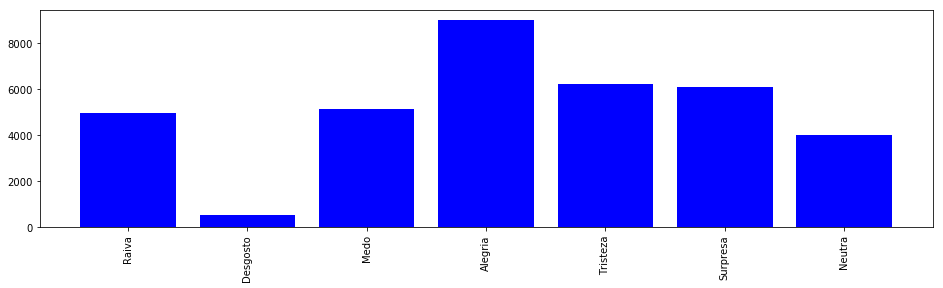

In [9]:
# Visualizando a distribuição por categoria de emoção
def visualiza_distribuicao():
    dist_y = qtd_por_emocao(imagens)
    dist_x = np.arange(len(classes_emocoes))
    x_label = classes_emocoes
    fig,ax = plt.subplots(figsize=(16,4))
    ax.bar(dist_x, dist_y, width=0.8, color='blue')
    ax.set_xticks(dist_x)
    ax.set_xticklabels(x_label, rotation=90)
    plt.show()
    
visualiza_distribuicao()

<h1>Preparar dados para treinamento</h1><br>
<p>A etapa preparar dados, é responsável por preparar o conjunto de dados para o treinamento, para que seja possível sua utilização pelo framework de aprendizado profundo.</p>

Formato da imagem: (48, 48)


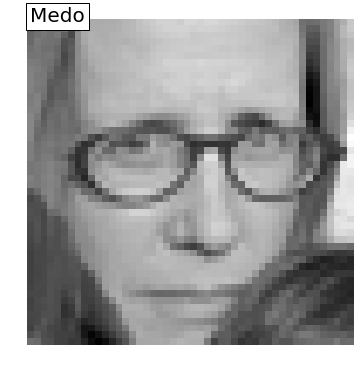

In [10]:
# Visualizando uma imagem a partir dos dados extraidos
# Seleciona uma imagem aleatoria
idx_img_aleatoria = random.randint(0, qtd_imagens)
img_aleatoria, emocao_aleatoria = imagens[idx_img_aleatoria][0], imagens[idx_img_aleatoria][1]
#print(img_aleatoria.size)
print("Formato da imagem: {}".format(np.array(img_aleatoria).T.shape))

plt.figure(figsize=(6,6))
plt.imshow(img_aleatoria, cmap='gray')
plt.text(0, 0, classes_emocoes[emocao_aleatoria], color='black', 
           bbox=dict(facecolor='white', alpha=1),fontsize=20)
plt.axis('off')
plt.show()

<h3>Extrair dados</h3>

In [11]:
# Função auxiliar para extrair os pixels da imagem
def _get_pixels_imagem(imagem, shape=(img_cols,img_rows)):
    """ Esta função é responsável por extrair os pixels 
        da imagem. Recebe como entrada uma objeto de imagem 
        python e retorna um numpy array contendo uma 
        lista de lista de todos os pixels. Pode ser
        alterado a dimensão da imagem pelo parametro shape.

        Args:
            imagem (PIL): objeto de imagem python.
            shape (tuple): tupla contendo o dimensão
            da imagem de saida.

        Returns:
            array (np.ndarray): retorna um array numpy.
    """
    # cria uma array numpy com uma lista contendo
    # todos os pixels da imagem
    pixel_values = np.array(list(imagem.getdata()))
    
    # redimensiona os pixels para formato 98x98
    pixel_values = pixel_values.reshape(shape)
    return pixel_values

Formato da array de pixels: (48, 48)


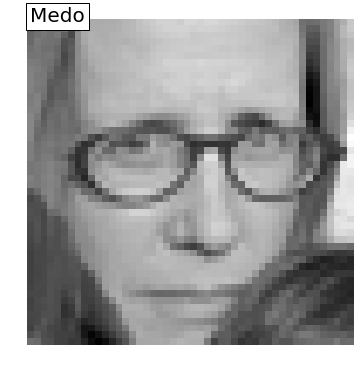

In [12]:
#Conferindo a extração dos pixels e remomtando a imagem

array_pixels = _get_pixels_imagem(img_aleatoria)
print("Formato da array de pixels: {}".format((array_pixels.shape)))

plt.figure(figsize=(6,6))
plt.imshow(array_pixels, cmap='gray')
plt.text(0, 0, classes_emocoes[emocao_aleatoria], color='black', 
           bbox=dict(facecolor='white', alpha=1),fontsize=20)
plt.axis('off')
plt.show()

In [13]:
# extrair os pixels das imagems
def extrair_dados(imagens):
    """ Esta função é responsável por extrair os pixels de 
        todas as imagem da base de dados.
        Recebe como entrada uma lista de objeto de
        imagem python e retorna uma lista de 
        numpy.ndarray contendo todos os pixels
        de todas as imagens.

        Args:
            imagens (list): lista objeto de imagem python.

        Returns:
            array (np.ndarray): retorna uma array numpay.
    """
    data = [] # para armazenar os dados
    array_emocoes = [] # para armazenar os descritores
    
    print("Extraindo os dados...")
    # para cada imagem
    for imagem in range(len(imagens)):
        # extrai o array de pixels da imagem
        data.append(_get_pixels_imagem(imagens[imagem][0]))
        # extrai a emocao que já estava definida na tupla
        array_emocoes.append(imagens[imagem][1])

    print("Quantidade de imagens extraidas:",len(data))
    print("Quantidade de emocoes extraidas:",len(array_emocoes))
    print("Extração de pixels completa!")
    return data, array_emocoes

In [14]:
# empilhar dados para trabalhar com o framework
data, array_emocoes = extrair_dados(imagens)

Extraindo os dados...
Quantidade de imagens extraidas: 35887
Quantidade de emocoes extraidas: 35887
Extração de pixels completa!


<h3>Empilhar dados</h3>

In [15]:
# Função que empilha o conjunto de dados,
# em formato de tupla para trabalhar com o deep learning
def empilhar_dados(dados):
    """ Esta função é responsável por empilhar os dados 
        para o formato que exigido para trabalho com o 
        framework Keras. Recebe como entrada lista de 
        dados e retorna uma tupla contendo a 
        quantidade de dados, dimensão x, e dimensão y.

        Args:
            dados (list): lista de dados.

        Returns:
            tuple: retorna uma tupla com 
            (quantidade, largura, altura).
    """
    print("Empilhando conjunto de dados:(quantidade, largura, altura)...")
    # faz uso da fucionalidade numpy de empilhamento
    dados_empilhados = np.stack(dados) 
    print("novo formato dos dados:", dados_empilhados.shape)
    return dados_empilhados

In [16]:
# empilhar imagens
print('Empilhando imagens...')
data = empilhar_dados(data)

print('Empilhando descritores de emoção...')
# empilhar descritores de emoção
labels = empilhar_dados(array_emocoes)

print("Fase de empilhamento completa!")

Empilhando imagens...
Empilhando conjunto de dados:(quantidade, largura, altura)...
novo formato dos dados: (35887, 48, 48)
Empilhando descritores de emoção...
Empilhando conjunto de dados:(quantidade, largura, altura)...
novo formato dos dados: (35887,)
Fase de empilhamento completa!


In [17]:
# Conferindo os pixels da imagem a partir dos dados estraidos.
print("Formato dos dados: {}".format(data[0].shape))
display(pd.DataFrame(data[0]))

Formato dos dados: (48, 48)


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,70,80,82,72,58,58,60,63,54,58,...,95,79,66,62,56,57,61,52,43,41
1,65,61,58,57,56,69,75,70,65,56,...,97,77,72,62,55,58,54,56,52,44
2,50,43,54,64,63,71,68,64,52,66,...,90,65,57,60,54,51,41,49,56,47
3,38,44,63,55,46,52,54,55,83,138,...,96,58,58,59,51,42,37,41,47,45
4,37,35,36,30,41,47,59,94,141,159,...,108,69,55,61,51,42,43,56,54,44
5,24,29,31,45,61,72,100,136,150,159,...,98,92,57,62,53,47,41,40,51,43
6,24,35,52,63,75,104,129,143,149,158,...,78,87,69,58,56,50,54,39,44,42
7,26,31,49,65,91,119,134,145,147,152,...,62,77,61,60,55,49,59,52,54,44
8,22,30,47,68,102,123,136,144,148,150,...,48,74,56,60,57,50,59,59,51,41
9,20,34,47,79,111,132,139,143,145,147,...,39,69,61,61,61,53,59,59,45,40


Formato da imagem: (48, 48)


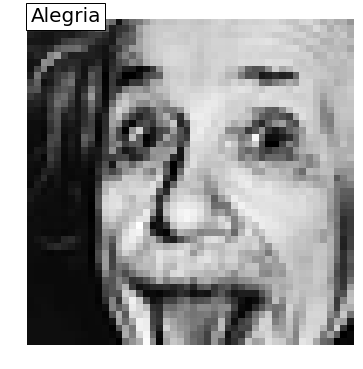

In [22]:
# Seleciona uma imagem aleatoria
idx_img_aleatoria = random.randint(0, qtd_imagens)
img_aleatoria, emocao_aleatoria = imagens[idx_img_aleatoria][0], imagens[idx_img_aleatoria][1]
#print(img_aleatoria.size)
print("Formato da imagem: {}".format(np.array(img_aleatoria).T.shape))

plt.figure(figsize=(6,6))
plt.imshow(img_aleatoria, cmap='gray')
plt.text(0, 0, classes_emocoes[emocao_aleatoria], color='black', 
           bbox=dict(facecolor='white', alpha=1),fontsize=20)
plt.axis('off')
plt.show()

In [23]:
# organizando dados para trabalhar com o keras
(X, y) = (data, labels)

In [24]:
# backup para plot na predição
print('Criando backup dos dados...')
X_test_orig = X
Y_test_orig = y
print('Backup - Estrutura do dados: ',X_test_orig.shape)
print('Backup - labels: ',len(Y_test_orig))
print('Backup completo!')

Criando backup dos dados...
Backup - Estrutura do dados:  (35887, 48, 48)
Backup - labels:  35887
Backup completo!


In [25]:
def amostragem(quantidade, limite):
    fig = plt.figure(figsize=(16,16))
    for i in range(quantidade):
        idx = random.randint(0,limite-1),
        input_img = X_test_orig[idx[0]].reshape(img_cols, img_rows)
        ax = fig.add_subplot(10,10,i+1)
        ax.imshow(input_img, interpolation='nearest', cmap='gray')
        idx_emocao = idx[0]
        plt.text(0, 0, classes_emocoes[Y_test_orig[idx_emocao]], color='black', 
           bbox=dict(facecolor='white', alpha=1),fontsize=20)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

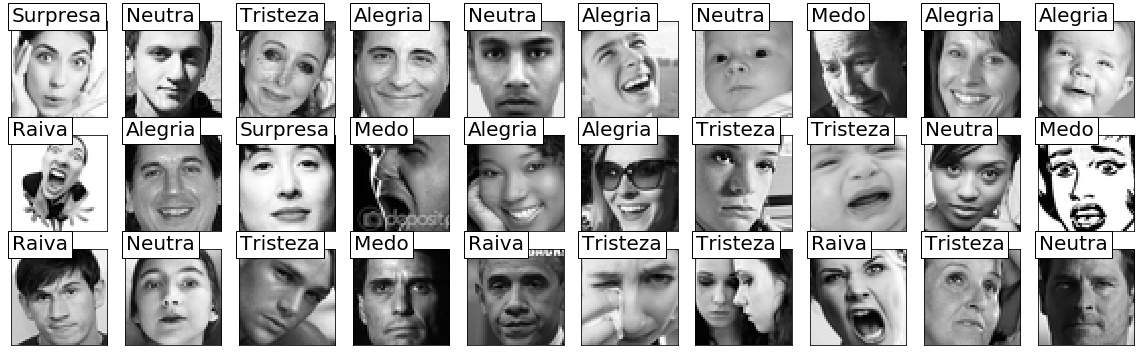

In [26]:
# Visualizando amostra dos dados
amosta = 30
amostragem(amosta, len(X_test_orig))

<h3>Separar dados</h3>

In [27]:
# Separando os dados para treinamento
def separar_treino_e_teste(imagens, descritores):
    """ Esta função é responsável por separa os dados 
        em conjunto de treino e teste. Recebe como 
        entrada tupla contendo todos os dados da 
        imagens e uma tupla contendo os descritores. 
        Retorna uma tupla contendo imagens de treino,
        descritores de treino, imagens de teste e 
        descritores de teste.

        Args:
            imagens (tuple): tupla de dados .

        Returns:
            tuple: tupla contendo dados de treino, dados de teste. 
    """
    # test_size=0.2 = percentual de separação 20% para teste
    # random_state = definindo a semente para escolha aleatoria
    print('Separando os dados em grupo de treino e teste...')
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                    test_size=0.2, random_state= int(qtd_imagens))
    print('Imagens separadas para treino: ',X_train.shape)
    print('Imagens separadas para teste: ',X_test.shape)
    print('Emoções separadas para treino: ',y_train.shape)
    print('Emoções separadas para teste: ',y_test.shape)
    return X_train, X_test, y_train, y_test

In [28]:
X_train, X_test, y_train, y_test = separar_treino_e_teste(X, y)

Separando os dados em grupo de treino e teste...
Imagens separadas para treino:  (28709, 48, 48)
Imagens separadas para teste:  (7178, 48, 48)
Emoções separadas para treino:  (28709,)
Emoções separadas para teste:  (7178,)


<h3>Formatar dados</h3>

In [34]:
# configura shape, adicionando a camanda de cor
# Shape é configurado de acordo com framework de background: tensorflow(tf) ou Theano(th)
def formatar_shape(X_train, X_test, canais=1):
    """ Esta função é responsável por formatar os dados
        para trabalhar com o deep learning, de acordo com
        o framework que está em background (tensorflow(tf) 
        ou Theano(th)).
        Recebe como parametro a quantidade de canais de cor
        que as imagens possuem.
        
        Args:
            X_train (tuple): imagens de treinamento
            X_train (tuple): imagens de teste
            canais (int): quantidade de canais de profundidade.
        Returns:
            tuple: tupla contendo dados de treino, dados de teste,
            e o shape dos dados, formatados para deep learning. 
    """
    print("Adicionando canais de cores na estrutura de dados...")
    # O framework theano trabalha com a quantidade de canais 
    # de cores a frente da dimesão da imagem
    if K.image_data_format() == 'channels_first': # = th
        shape = (canais, img_cols, img_rows)
        #shape = (1, img_cols, img_rows)
        print("Trabalhando com theano:", shape)
    # O framework tensorflow trabalha com a quantidade de canais
    # de cores apos a dimesão da imagem
    else:  # channel_last = tf
        shape = (img_cols, img_rows, canais)
        #shape = (img_cols, img_rows, 1)
        print("Trabalhando com tensorflow:",shape)
    print("Novo formato para estrutura de dados contendo o canal de cor: ",shape)
    print('Alterando o formato das imagens, colocando a estrutura com canal de cor...')
    X_train = X_train.reshape((X_train.shape[0],) + shape).astype('float32')
    X_test = X_test.reshape((X_test.shape[0],) + shape).astype('float32')
    print('Novo formato das imagens separadas para treino: ',X_train.shape)
    print('Novo formato das imagens separadas para teste: ',X_test.shape)
    # cada pixels é normalizado = pixel = pixel / 255
    print('Normalizando os dados...')
    X_train /= 255
    X_test /= 255
    return X_train, X_test, shape

In [35]:
X_train, X_test, shape = formatar_shape(X_train, X_test)

Adicionando canais de cores na estrutura de dados...
Trabalhando com tensorflow: (48, 48, 1)
Novo formato para estrutura de dados contendo o canal de cor:  (48, 48, 1)
Alterando o formato das imagens, colocando a estrutura com canal de cor...
Novo formato das imagens separadas para treino:  (28709, 48, 48, 1)
Novo formato das imagens separadas para teste:  (7178, 48, 48, 1)
Normalizando os dados...


<h3>Criar matriz one-hot</h3>

In [29]:
# Criando a classificação
# Converte um vetor de classe (inteiros) em matriz de classe verdade (binária).
def criar_matriz_verdade(y_train, y_test):
    """ Esta função é responsável por criar uma matriz
        verdade para todos os descritores do conjunto de dados.
        Recebe como parametro os descritores de treino e teste.
        
        Args:
            Y_train (tuple): descritores de emoção de treinamento
            Y_test (tuple): descritores de emoção de teste 
        
        Returns:
            tuple: tupla contendo as matrizes verdade dos
            descritores de treino, dados de teste,
    """
    print('Criando a matriz de classificação binária...')
    # Classificando os descritores de treino
    Y_train = np_utils.to_categorical(y_train)
    # Classificando os descritores de teste
    Y_test = np_utils.to_categorical(y_test)

    # verificando a quantidade de classes encontradas
    n_treino = Y_train.shape[1]
    print('Classes encontradas para imagens: ', n_treino)

    # verificando a quantidade de classes encontradas
    n__teste = Y_test.shape[1]
    print('Classes encontradas para emocoes: ', n__teste)
    return Y_train, Y_test

In [30]:
Y_train, Y_test = criar_matriz_verdade(y_train, y_test)

Criando a matriz de classificação binária...
Classes encontradas para imagens:  7
Classes encontradas para emocoes:  7


In [31]:
# visualizando matriz verdade
print(classes_emocoes)
print()
print(Y_train[:5])
print('Formato da matriz verdade de treino:',Y_train.shape)
print()
print(Y_test[:5])
print('Formato da matriz verdade de teste:',Y_test.shape)

['Raiva', 'Desgosto', 'Medo', 'Alegria', 'Tristeza', 'Surpresa', 'Neutra']

[[ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]]
Formato da matriz verdade de treino: (28709, 7)

[[ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]]
Formato da matriz verdade de teste: (7178, 7)


<h1>Criar rede neural profunda</h1>
<p>Nesta etapa do desenvolvimento é criado a arquitetura da rede neural semelhante a rede Deep-Emotive, treinada anteriormente. A rede neural profunda Deep-Emotive possui a arquitetura ilustrada na figura abaixo. Foi alterado o formato das imagens de entrada e a quantidade final de saídas no classificador</p>

In [32]:
display(HTML('''<img src="./util/Diagrama - Arquitetura da rede neural -FINAL.png">'''))

In [36]:
def criar_nova_rede_cnn_profunda(num_classes, shape=shape):
    """ Esta função é responsável por criar uma nova rede neural
         baseada na estrutura da rede Deep-Emotive.
         é alterado o shape das imagens de entrada e 
         a quantidade de emoções classificadas.
         Recebe como parametro a quantidade de emoções que
         serão categorizadas

        Args:
            num_classes (int): quantidade de emoções que serão categorizadas

        Returns:
            model: modelo da rede neural cnn compilado
    """
    # Bloco de extração de características
    feature_layers = [
        Conv2D(64, (5,5),
               padding='same',
               input_shape=(shape)), # altera o formato de entrada da imagens (48x48)
        PReLU(),
        AveragePooling2D(pool_size=(2, 2)),
        Conv2D(128, (5,5)),
        PReLU(),
        AveragePooling2D(pool_size=(2, 2)),
        Conv2D(256, (5,5)),
        PReLU(),
        AveragePooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
    ]
    # Bloco de classificação
    classification_layers = [
        Dense(512),
        PReLU(),
        Dropout(0.5),
        Dense(num_classes), # Altera a quantidade de emoções na ultima camada
        Activation('softmax')
    ]
    # create complete model
    model = Sequential(feature_layers + classification_layers)
    # Compilando o modelo que estava salvo
    # lr: taxa de aprendizado
    # decay: tamanho do passo da caída do gradiente
    adam = optimizers.Adam(lr=1e-3, decay=1e-5)    

    # Copilando o modelo
    # Função de apredizado será cross-entropy (https://en.wikipedia.org/wiki/Cross_entropy)
    # métrica de reconhecimento será precisão.
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

In [37]:
model_final = criar_nova_rede_cnn_profunda(len(classes_emocoes))

In [38]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 48, 48, 64)        147456    
_________________________________________________________________
average_pooling2d_1 (Average (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       204928    
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 20, 20, 128)       51200     
_________________________________________________________________
average_pooling2d_2 (Average (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 256)         819456    
__________

<h3>Configurando a transferência de aprendizado</h3>
<p>Esta base de dados se enquadra na quarta categoria de transferência de aprendizado, pois ela é grande e dissimilar à base de dados utilizada para treinamento da rede DeepEmotive.
Foi utilizado apenas a estrutura da base de dados DeepEmotive, e a rede foi treinada novamente do zero.</p>

In [40]:
# chekpoint para salvar o mehlor aprendizado enter as epocas
filepath="./transfer learning/fer2013/checkpoint-transfer-learning-fer2013-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath,  # caminho para o modelo salvo
                             monitor= 'val_acc', # qual parametro vai acompanhar
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # sobreescreve o modelo apenas se for o melhor
                             mode='auto') # dependecia de acorco com o monitor

In [41]:
# Treinando o modelo DNN para 01 época
# Função FIT: realiza o treinamento até uma quantidade de épocas determinada.
# parametro validation_data: Dados para avaliar a perda do gradiente ao final de cada época
# parametro batch_size: numero de amostras para atualizar a perda do gradientes
# Paramentro verbose : 0 = silent, 1 = verbose, 2 = one log line per epoch.
# %time = medindo tempo do treino
PESOS_SALVOS = './pesos/checkpoint-transfer-learning-fer2013-19-0.61.hdf5'

# Flag True ou false para retreinar a rede
if True and os.path.exists(PESOS_SALVOS):    
    print('Carregando pesos salvos de treino anterior...')
    model_final.load_weights(PESOS_SALVOS)
    print('Pesos carregados com sucesso!')
else:
    # treinando a DNN para 20 épocas
    #callback_list=[monitor,checkpoint]
    callback_list=[checkpoint]
    print('Treinando a DNN...')
    %time history = model_final.fit(X_train, Y_train, validation_data=(X_test, Y_test), callbacks=callback_list, epochs=20, batch_size=128, verbose=1)
    print('Treinanmeto finalizado!')

Carregando pesos salvos de treino anterior...
Pesos carregados com sucesso!


In [42]:
#MELHOR_TREINO = './transfer learning/fer2013/checkpoint-transfer-learning-fer2013-19-0.61.hdf5'
MELHOR_TREINO = './pesos/checkpoint-transfer-learning-fer2013-19-0.61.hdf5'
MODELO_SALVO_JSON = './transfer learning/fer2013/model-transfer-learning-kaggle.json'

In [43]:
# Salvando o modelo criado
print('Salvando o modelo...')
# serialize model para formato JSON
model_json = model_final.to_json()
with open(MODELO_SALVO_JSON, "w") as json_file:
    json_file.write(model_json)
    print('Modelo salvo com sucesso!')

Salvando o modelo...
Modelo salvo com sucesso!


In [44]:
# Carregando o modelo salvo
# Lendo o modelo salvo em arquivo para um novo modelo
print("Carregando o modelo...")
json_file = open(MODELO_SALVO_JSON, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
print('Modelo carregado com sucesso!')

Carregando o modelo...
Modelo carregado com sucesso!


In [45]:
# Carregando o melhor pesos do checkout para para o novo modelo
print("Carregando os melhores pesos...")
loaded_model.load_weights(MELHOR_TREINO)

# Compilando o modelo que estava salvo
# lr: taxa de aprendizado
# decay: tamanho do passo da caída do gradiente
adam = optimizers.Adam(lr=1e-3, decay=1e-5)    

# Copilando o modelo
# Função de apredizado será cross-entropy (https://en.wikipedia.org/wiki/Cross_entropy)
# métrica de reconhecimento será precisão.
loaded_model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
print("Carregamento dos melhores pesos completo!")

Carregando os melhores pesos...
Carregamento dos melhores pesos completo!


In [46]:
# Avaliando a precisção do modelo carregado depois do fit
print('Metricas do Modelo: {}'.format(loaded_model.metrics_names))
loaded_model_metricas = loaded_model.evaluate(X_test, Y_test, verbose=1)
print("Erro de: %.2f%%" % (100-loaded_model_metricas[1]*100))
print("Precisão de: %.2f%%" % (loaded_model_metricas[1]*100))

Metricas do Modelo: ['loss', 'acc']
7178/7178 [==============================] - 69s    
Erro de: 39.29%
Precisão de: 60.71%


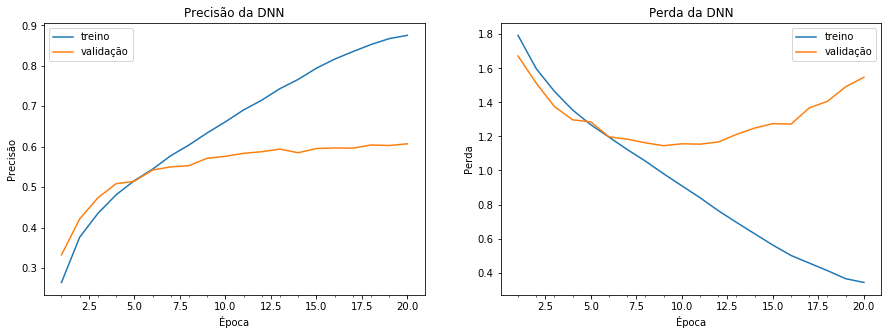

In [117]:
def plot_model(history):

    # Cria subplots
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Precisão
    axs[0].plot(range(1,len(history.history['acc'])+1),history.history['acc'])
    axs[0].plot(range(1,len(history.history['val_acc'])+1),history.history['val_acc'])
    axs[0].set_title('Precisão da DNN')
    axs[0].set_ylabel('Precisão')
    axs[0].set_xlabel('Época')
    axs[0].set_xticks(np.arange(1,len(history.history['acc'])+1),len(history.history['acc'])/10)
    axs[0].legend(['treino', 'validação'], loc='best')
    
    # Perda
    axs[1].plot(range(1,len(history.history['loss'])+1),history.history['loss'])
    axs[1].plot(range(1,len(history.history['val_loss'])+1),history.history['val_loss'])
    axs[1].set_title('Perda da DNN')
    axs[1].set_ylabel('Perda')
    axs[1].set_xlabel('Época')
    axs[1].set_xticks(np.arange(1,len(history.history['loss'])+1),len(history.history['loss'])/10)
    axs[1].legend(['treino', 'validação'], loc='best')
    
    # Visualizar
    plt.show()
        
plot_model(history)

<h1>Predição</h1>
<p>A predição é a etapa final do processamento de execução do protótipo, e é responsável por apresentar a classificação de uma ou mais imagens, baseado no aprendizado adquirido pela rede, na fase de treinamento</p>

In [47]:
def predizer(model, imagens):
    """Esta função é responsável por realizar a predição 
       do conjunto de dados. Recebe como parametro o 
       modelo da rede, e retorna uma tupla contendo a 
       matriz de probabilidade e a matriz da classificação.

       Args:
           model (sequencial): modelo da rede neural
           treinado.
           imagens (list): lista contendo as imagens
           para predizer a emoção
       Returns:
           np.array: matriz de probabilidade
           np.array: matriz da classificação
    """
    print('Predição da(s) imagem(ns)...')
    m_probabilidade = model.predict(X_test, batch_size=32, verbose=1)
    m_predicao = [np.argmax(prob) for prob in m_probabilidade]
    
    print('Predição completa!')
    print('Quantidade de imagens analisadas: ', len(m_predicao))
    return m_probabilidade, m_predicao

In [48]:
y_probabilidade, predicted = predizer(loaded_model, X_test)

Predição da(s) imagem(ns)...
7178/7178 [==============================] - 69s    
Predição completa!
Quantidade de imagens analisadas:  7178


In [49]:
# Verificando a precisão por classe
# precision= A precisão é a razão onde é o número de positivos verdadeiros e o número de falsos positivos
# recall= O recall é a razão onde é o número de positivos verdadeiros e o número de falsos negativos
# f1-score= A média harmônica ponderada da precisão e recall
# support= O suporte é o número de ocorrências de cada classe verdade

print(classification_report(np.argmax(Y_test, axis=1), predicted, target_names=classes_emocoes))

             precision    recall  f1-score   support

      Raiva       0.55      0.47      0.51      1008
   Desgosto       0.90      0.55      0.68       102
       Medo       0.48      0.45      0.47      1006
    Alegria       0.82      0.78      0.80      1789
   Tristeza       0.48      0.47      0.48      1200
   Surpresa       0.78      0.72      0.75       838
     Neutra       0.48      0.65      0.56      1235

avg / total       0.62      0.61      0.61      7178



<h3>Amostras da predição</h3>
<p>Nesta etapa é ilustrado algumas imagens que foram preditas pela rede Deep-Emotive.<br>
São selecionadas trinta imagens aleatórias e preditas, o resultado é plotado.</p>

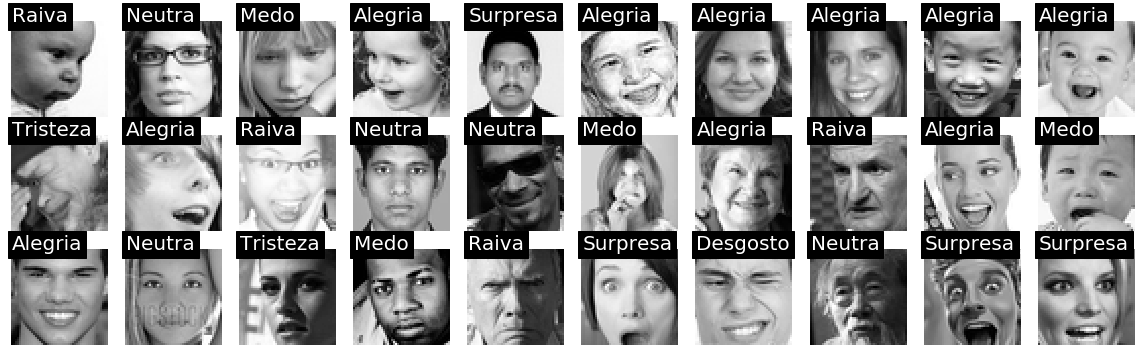

In [50]:
amosta = 30
fig = plt.figure(figsize=(16,16))
for i in range(amosta):
    #plt.subplot(1, amosta, i+1)
    # Seleciona uma imagem aleatoria
    idx_img_aleatoria = random.randint(0, len(predicted)-1)
    img_aleatoria = X_test[idx_img_aleatoria]
    
    ax = fig.add_subplot(10,10,i+1)
    # Visualiza a imagem escolhida aleatoriamente
    plt.imshow(img_aleatoria.reshape(img_cols, img_rows), interpolation='nearest', cmap='gray')

    # Visualiza o label
    plt.text(0, 0, classes_emocoes[predicted[idx_img_aleatoria]], color='white', 
             bbox=dict(facecolor='black', alpha=1), fontsize=20)
        
    plt.axis('off')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.tight_layout()
plt.show()

In [51]:
# Função para matriz de confusão da predição

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusão',
                          cmap=plt.cm.copper):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('Base de teste')
    plt.xlabel('Predições')

Verificando quantidade de imagens da predição: 7178
Verificando formato dos dados de testes: (7178, 7)


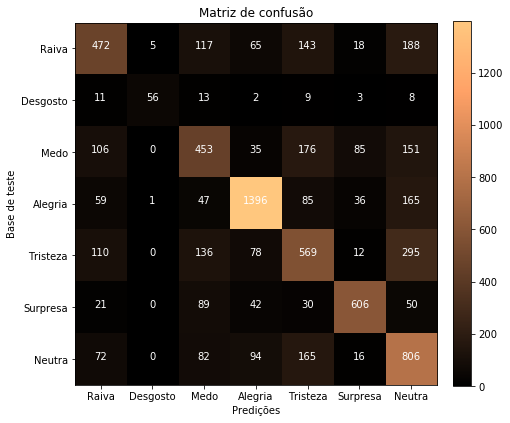

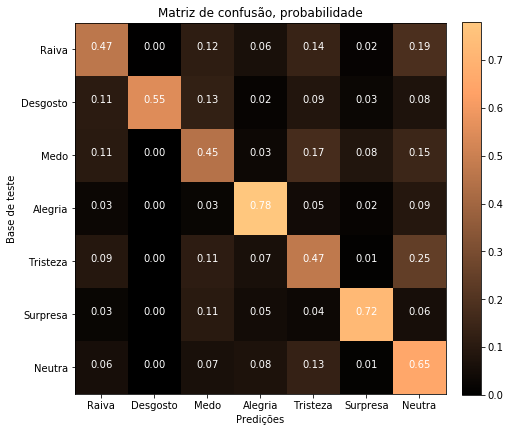

In [52]:
# Visualizando matriz de confusão da predição
#classes = ['alegria', 'desgosto', 'desprezo', 'medo', 'neutral', 'raiva', 'surpresa', 'tristeza']
# Precisa ter o mesmo formato
print('Verificando quantidade de imagens da predição: {}'.format(len(predicted)))
print('Verificando formato dos dados de testes: {}'.format(Y_test.shape))


cnf_matrix = confusion_matrix(np.argmax(Y_test, axis=1), predicted)
np.set_printoptions(precision=2)

# Visualizando a matriz de confusão sem normalização.
# mosta a quantidade de imagens classificadas para cada label
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=classes_emocoes,
                      title='Matriz de confusão')

# Visualizando a matriz de confusão com normalização.
# mosta a precisão para cada label classificado
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=classes_emocoes, normalize=True,
                      title='Matriz de confusão, probabilidade')

plt.show()